![MOSEK ApS](https://mosek.com/files/mosek_logo_color.png )


Smallest sphere enclosing a set of points.
===========================

The aim of this tutorial is two-fold

1. Demostrate how to write a conic quadratic model in `Fusion` in a very simple and compact way.
2. Show how and way the dual formulation may solved more efficiently.


Our problem is the defined as:

**Find the smallest sphere that encloses a set of** $k$ **points** $p_i \in \mathbb{R}^n$. 

The problem boils down to determine the sphere center $p_0\in \mathbb{R}^n$ and its radius $r_0\geq 0$, i.e.


\begin{equation}
  \begin{aligned}
\min \max_{i=1,\dots,k} \| p_i - p_0\|_2 \\
  \end{aligned}
\end{equation}

The maximum in the objective function can be easily, i.e.

\begin{equation}
  \begin{aligned}
\min r_0 & & &\\
s.t.& & &\\
& r_i \geq \| p_i - p_0\|_2 ,& \quad & i=1,\ldots,k\\
\end{aligned}
\end{equation}

The SOCP formulation reads

\begin{equation}
  \begin{aligned}
\min r_0 & & &\\
s.t.& & &\\
& (r_0,p_i - p_0) \in Q^{(n+1)}, & \quad & i=1,\ldots,k.
\end{aligned}
\end{equation}

The `fusion` implementatin starts defining the optimization model:

Before defining the constraints, we note that we can write


\begin{equation}
r = \left(r_0,\ldots,r_0\right)^T \in \mathbb{R}^k
\end{equation}

and 

\begin{equation}
P = \left(p_0,\ldots,p_k\right)^T \in \mathbb{R}^{k\times n}.
\end{equation}

so that 

\begin{equation}
(r_0,p_i - p_0) \in Q^{(n+1)},  \quad  i=1,\ldots,k.
\end{equation}

can be compactly expressed as 

\begin{equation}
(r,P) \in \Pi Q^{(n+1)}.
\end{equation}

Now we are ready for a compact implementation in `Fusion`:

In [34]:
from mosek.fusion import *

def primal_problem(P):
    
    k= len(P)
    if k==0: return -1,[]

    n= len(P[0])
    
    with Model("minimal sphere enclosing a set of points - primal") as M:

        r0 = M.variable(1         , Domain.greaterThan(0.))
        p0 = M.variable(NDSet(1,n), Domain.unbounded())

        R0 = Variable.repeat(r0,k)
        P0 = Variable.repeat(p0,k)
        M.constraint( Expr.hstack( R0, Expr.sub( P0 , DenseMatrix(P) ) ), Domain.inQCone())

        M.objective(ObjectiveSense.Minimize, r0)
        M.setLogHandler(open('logp','wt'))

        M.solve()

        return r0.level()[0], p0.level()
           

For sake of simplicity we will consider

* $n=2$,
* no restriction on the sphere center location.

Our input data will be generate randomly around the origin with a standard normal distibution.

Here it is:

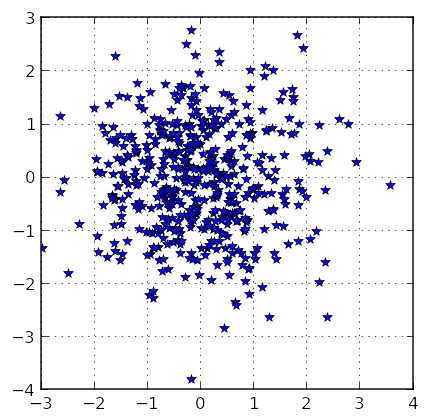

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random

def plot_points(p, p0=[], r0=0.):
    n,k= len(p0), len(p)
    
    plt.rc('savefig',dpi=120)

    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.plot([ p[i][0] for i in range(k)], [ p[i][1] for i in range(k)], 'b*')
    
    if len(p0)>0:
        ax.plot(  p0[0], p0[1], 'r.')
        ax.add_patch( mpatches.Circle( p0,  r0 ,  fc="w", ec="r", lw=1.5) )
    plt.grid()
    plt.show()

n = 2
k = 500

p=  [ [random.gauss(0.,1.) for nn in range(n)] for kk in range(k)]

plot_points(p)

We will also store the solver output in a file to use it later on. And then just solve the problem.

In [36]:
r0,p0 = primal_problem(p)

print "r0^* = ", r0
print "p0^* = ", p0

r0^* =  3.43202414409
p0^* =  [0.3258664175584296, -0.41190076137026743]


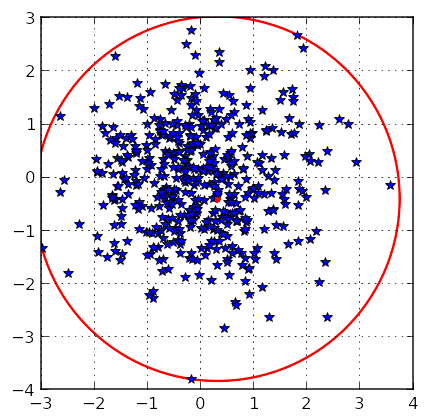

In [37]:
plot_points(p,p0,r0)

Dual Formulation 
-----------------------

The dual problem can be determined in few steps following basic rules. 

The final result is:

\begin{aligned}
    \max & \sum_i b_i^T y_i \\
    & \sum_i y_i = c \\
    & y_i \in \mathcal{Q}^{n+1}
\end{aligned}


where $c=\left(1, 0_n\right)^T$ and $b_i=(0,p_i)$.


Introducing 

\begin{equation}
 Y = \left[ y_1, \ldots,y_k  \right]^T, B=\left[ b_1,\ldots,b_k\right]^T
\end{equation}

we obtain the form

\begin{aligned}
    \max & \left< B, Y \right> \\
    & e^T Y  = c \\
    & Y_{i,:} \in \mathcal{Q}^{n+1},
\end{aligned}

where $e$ is a vector with all entries equal to one.

The ``Fusion`` code is the following:


In [38]:
def dual_problem(P):
        
    k= len(P)
    if k==0: return -1,[]

    n= len(P[0])
    
    with Model("minimal sphere enclosing a set of points - dual") as M:
    

        y= M.variable(NDSet(k,n+1), Domain.inQCone(k,n+1))
        
        e= [1.0 for e in range(k)]
        c= [1.] + [0. for i in range(n)]
        
        M.constraint(Expr.mul(e, y), Domain.equalsTo(c) )

        M.objective(ObjectiveSense.Maximize, Expr.dot( DenseMatrix(P), y.slice([0,1],[k,n+1])) )
 
        M.setLogHandler(open('logd','wt'))

        M.solve()

    
dual_problem(p)

Notice that we have restricted the objective function terms only to those that are non zeros.


Let's take a closer look to the solver output:

In [39]:
!tail  log*

==> logd <==
12  4.2e-04  1.6e-06  8.3e-07  1.00e+00   3.432102923e+00   3.432081665e+00   8.3e-07  0.01  
13  3.4e-05  1.3e-07  6.8e-08  1.00e+00   3.432029156e+00   3.432027434e+00   6.8e-08  0.01  
14  5.7e-06  2.2e-08  1.2e-08  1.00e+00   3.432024619e+00   3.432024338e+00   1.2e-08  0.01  
15  9.1e-07  3.5e-09  1.8e-09  1.00e+00   3.432024122e+00   3.432024081e+00   1.8e-09  0.01  
16  1.1e-07  4.0e-10  1.8e-08  1.00e+00   3.432024139e+00   3.432024071e+00   2.1e-10  0.01  
17  3.3e-08  2.6e-11  7.1e-08  1.00e+00   3.432023826e+00   3.432024071e+00   1.3e-11  0.01  
18  3.3e-08  2.6e-11  7.1e-08  1.00e+00   3.432023826e+00   3.432024071e+00   1.3e-11  0.01  
Interior-point optimizer terminated. Time: 0.01. 

Optimizer terminated. Time: 0.01    

==> logp <==
5   2.1e-03  1.4e-03  2.7e-03  1.19e+00   3.565007694e+00   3.668162762e+00   1.4e-03  0.01  
6   7.0e-04  4.5e-04  9.0e-04  1.10e+00   3.462165206e+00   3.493555539e+00   4.5e-04  0.01  
7   8.8e-05  5.7e-05  1.1e-04  1.02e+00

In [40]:
%%bash
grep Scalar log*
grep Cones log*
grep Constraints log*


logd:  Scalar variables       : 1500            
logd:Optimizer  - Scalar variables       : 1500              conic                  : 1500            
logp:  Scalar variables       : 1503            
logp:Optimizer  - Scalar variables       : 1500              conic                  : 1500            
logd:  Cones                  : 500             
logd:Optimizer  - Cones                  : 500
logp:  Cones                  : 500             
logp:Optimizer  - Cones                  : 500
logd:  Constraints            : 3               
logd:Optimizer  - Constraints            : 3
logp:  Constraints            : 1500            
logp:Optimizer  - Constraints            : 1497


Why is that? `Fusion` performs the following transformation:

\begin{equation}
Ax - b \in \mathcal{K} \rightarrow \quad \left\lbrace\begin{array}{ll} y = Ax-b\\ y\in \mathcal{K} \end{array}\right.
\end{equation}

The reason is to ensure that each variable belongs only in one cone.

**But this is not the reason: **

* **MOSEK** uses a primal-dual algorithm that solves both primal and dual at the same time,
* therefore internally there is no difference in terms of problem size.

**So why is the dual formulation so much faster?**

The answer comes from a closer inspection to the solver output, in particular the reported `flops`:


In [41]:
!grep flop log* 

logd:Factor     - dense dim.             : 0                 flops                  : 1.30e+04        
logp:Factor     - dense dim.             : 5                 flops                  : 9.68e+04        


In [42]:
!grep flop log* | cut -d':' -f 4 | xargs printf "1/(%f/%f)\n" | bc -l

7.44615384615384615403


In [43]:
!grep "Interior-point optimizer" log* | cut -d':' -f 3| cut -d'.' -f1-2  | xargs printf "1/(%f/%f)\n" | bc -l

2.00000000000000000000


When moving from theory to practical implementation, **MOSEK** is somehow biased towards the primal, i.e. the formulation we input:

* some steps, most notably factorizations, are in practice order dependent,
* it is important to not be mislead by the problem dimension looking only at the number of variables, constraints and cones,
* if performance are a concern, both primal and dual should be tried.

Hopefully we will include an automatic dualizer tool in the future release. *But it will be still a heuristic.*

---------------------------------------------------------------------------------------------------------------

The **MOSEK** logo and name are trademarks of Mosek ApS.

The code is provided as-is. Compatibility with future release of **MOSEK** or the `Fusion API` are not guaranteed.

For more information contact [support_at_mosek.com](mailto:support@mosek.com)

---------------------------------------------------------------------------------------------------------------


<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">The MOSEK collection of iPython Notebook</span> by <a xmlns:cc="http://creativecommons.org/ns#" href="www.mosek.com" property="cc:attributionName" rel="cc:attributionURL">MOSEK ApS</a> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.<br />Based on a work at <a xmlns:dct="http://purl.org/dc/terms/" href="https://github.com/MOSEK" rel="dct:source">https://github.com/MOSEK</a>.<br />Permissions beyond the scope of this license may be available at <a xmlns:cc="http://creativecommons.org/ns#" href="www.mosek.com" rel="cc:morePermissions">www.mosek.com</a>.

In [45]:
from IPython.core.display import HTML
def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML(styles)
css_styling()
